# <center>Численное решение</center>

__Необходимые модули:__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc

__Получение входных параметров:__

In [2]:
def get_entry_conditions( n=1 ):
    """
    Входные данные:
    n - номер примера
    n = 1 - первый тестовый пример
    n = 2 - второй тестовый пример
    n = 3 - первый собственный пример
    n = 4 - второй собственный пример
    
    Возвращает:
    a - коэффициент
    f - функцию внешних источников тепла
    phi - начальное условие
    ph1 - левое граничное условие
    ph2 - правое граничное условие
    sol - аналитическое решение
    """
    if n == 1:
        a = 1 / 5
        f = lambda x, t: 0.
        phi = lambda x: 15 * np.sin(5*x)
        ph1 = lambda t: 0
        ph2 = lambda t: 0
        l = 0.5 * np.pi
        sol = lambda x, t: 15 * np.sin(5*x) * np.exp(-t)
    
    elif n == 2:
        a = 1 / 5
        f = lambda x, t: 0.
        phi = lambda x: 15 * np.sin(5*x) + 5
        ph1 = lambda t: 5
        ph2 = lambda t: 0
        l = 0.5 * np.pi
        sol = lambda x, t: 15 * np.sin(5*x) * np.exp(-t) + 5
    
    elif n == 3:
        a = 1
        f = lambda x, t: 0.
        phi = lambda x: 9 * np.sin(5*x) - 5 * x
        ph1 = lambda t: 0
        ph2 = lambda t: - 5
        l = 0.5 * np.pi
        sol = lambda x, t:  9 * np.sin(5*x) * np.exp(-25*t) - 5 * x
        
    elif n == 4:
        a = 2**(1 / 2)
        f = lambda x, t: -20.
        phi = lambda x: - 18 * np.sin(3*x) + 5 * x**2
        ph1 = lambda t: 0
        ph2 = lambda t: 5 * np.pi
        l = 0.5 * np.pi
        sol = lambda x, t: - 18 * np.sin(3*x) * np.exp(-18*t) + 5 * x**2
        
    return a, f, phi, ph1, ph2, l, sol

__Метод прогонки:__

In [3]:
def progonka(a, b, c, f, ph1, ph2, h):
    """
    Входные данные:
    a - коэффициент А_i
    b - коэффициент B_i
    c - коэффициент C_i
    f - правая часть (F_i)^j
    ph1 - левое граничное условие, передано значение на нужном уровне времени
    ph2 - правое граничное условие, передано значение на нужном уровне времени 
    h - шаг по x
    
    Возвращает:
    res - массив
    """
    alpha = [0]
    beta = [ph1]
    n = len(f)
    for i in range(1, n - 1):
        alpha.append(-a / (b + c * alpha[i - 1]))
        beta.append((f[i] - c * beta[i - 1]) / (b + alpha[i - 1] * c))
    res = np.zeros(n)
    res[n - 1] = (h * ph2 + beta[n - 2]) / (1 - alpha[n - 2])

    for i in range(n - 2, -1, -1):
        res[i] = alpha[i] * res[i + 1] + beta[i]
    return res

__Получение сетки:__

In [4]:
def get_grid(t, h, xs, xl, T, a, phi, ua, ub,f):
    """
    Входные данные:
    t - шаг по времени
    h - шаг по координате
    xs - начальная координата
    xl - конечная координата
    T - данное время
    a - коэффициент
    phi - начальное условие
    ua - граничное левое условие
    ub - граничное правое условие
    f - функция внешних источников тепла
    
    Выходные данные:
    u - сетка
    """
    tn = int(T / t) + 1
    hn = int((xl - xs) / h) + 1
    
    u = np.zeros((tn, hn))
    
    u[0] = np.array([phi(i * h) for i in range(0, hn)])
    
    A = - (t * a**2) / (h**2)
    C = A
    B = 1 + (2 * t * a**2) / (h**2)
    for j in range(tn - 1):
        F = np.array([(u[j][i] + t * f(i * h, j * t)) for i in range(0, hn)])
        u[j + 1] = progonka(A, B, C, F, ua(j), ub(j), h) 
    return u

__Правило Рунге:__

In [5]:
def runge_rul(u, u2, p):
    r = u2.copy()
    for i in range(u2.shape[0]):
        r[i] = u[i * 2][::2]
    r = r.reshape(u2.shape[0] * u2.shape[1])
    u2 = u2.reshape(u2.shape[0] * u2.shape[1])
    
    return  max(abs((r - u2) / (2**p - 1)))

__Решение с заданной точностью:__

In [6]:
def get_solution(xs, xl, T, acc, phi, a, ua, ub, f, t_):
    """
    Входные данные:
    xs - цначальная координата
    xl - конечная координата
    T - данное время
    a - коэффициент
    phi - начальное условие
    ua - граничное левое условие
    ub - граничное правое условие
    f - функция внешних источников тепла
    acc - точность
    
    Выходные данные:
    u - решение
    h - шаг по координате
    t - шаг по времени
    """
    h0 = xl / 10
    t0 =  0.1
    j = 2 
    t = t0 / j 
    h = h0 / 2
    
    u2 = get_grid(t0, h0, xs, xl, T, a, phi, ua, ub, f)
    u = get_grid(t, h, xs, xl, T, a, phi, ua, ub, f)
    
    i = int(T/t_/t0)
    while runge_rul(u, u2, 1) > acc:
        print("Погрешность: {}".format(round(runge_rul(u, u2, 1), 3)))
        t /= j
        h /= 2
        i *= j
        u2 = u
        u = get_grid(t, h, xs, xl, T, a, phi, ua, ub, f)
        
    return u, h, t, i * j

__Функция рисования трёх графиков:__

In [7]:
def draw(a, b, u, u_analytic, k, n):
    """
    Рисует график аналитического решения, численного и график погрешности.
    
    Входные параметры:
    a - начальная координата
    b - конечная координата
    u - численное решение
    u_analytic - аналитическое решение
    k - время на котором выводится погрешность
    n - число выводимых временных отрезков
    
    Выходные параметры:
    1 - график аналитического решения
    2 - график численного решения
    3 - график погрешности
    """
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, figsize=(10,15))
    
    x = np.linspace(0, l, u[0].shape[1])
    N = u[0].shape[0]
    t = u[2]
    
    ax1.set_title('Численное решение')
    ax1.set_xlim((0, l))
    for i in range(0, N, round(N / n)):
        ax1.plot(x, u[0][i], label='t={}'.format(round(i * t, 2)))
               
    ax2.set_title('Аналитическое решение')
    ax2.set_xlim((0, b))
    for i in range(0, N, round(N / n)):
        ax2.plot(x, u_analytic(x,i * t))

    ax3.set_title('Погрешность при t = {}'.format(k * t))
    ax3.set_xlim((0, l))
    ax3.plot(x, abs(u[0][k] - u_analytic(x, k * t)))
    
    fig.legend()

__Первый тестовый пример:__

In [8]:
a, f, phi, ph1, ph2, l, sol1 = get_entry_conditions(1)

u1 = get_solution(0, l, 4, 0.01, phi, a, ph1, ph2, f, 4)

Погрешность: 2.968
Погрешность: 0.995
Погрешность: 0.45
Погрешность: 0.216
Погрешность: 0.106
Погрешность: 0.052
Погрешность: 0.026
Погрешность: 0.013


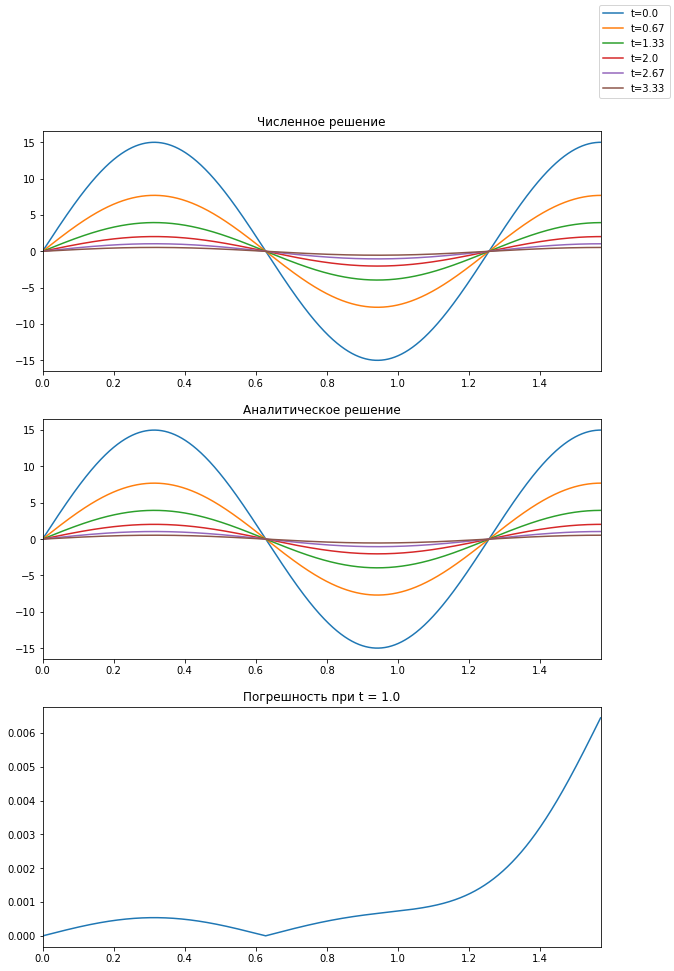

In [9]:
draw(0, l, u1, sol1, u1[3], 6)

In [10]:
df1 = pd.DataFrame(u1[0]) 
df1

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,5120
0,0.0,0.023010,0.046019,0.069029,0.092038,0.115047,0.138056,0.161065,0.184073,0.207081,...,14.998571,14.998871,14.999135,14.999365,14.999559,14.999718,14.999841,14.999929,14.999982,15.000000
1,0.0,0.023005,0.046010,0.069015,0.092020,0.115025,0.138029,0.161033,0.184037,0.207040,...,14.995578,14.995871,14.996128,14.996348,14.996532,14.996679,14.996790,14.996864,14.996901,14.996901
2,0.0,0.023001,0.046001,0.069002,0.092002,0.115003,0.138002,0.161002,0.184001,0.207000,...,14.992589,14.992878,14.993132,14.993349,14.993530,14.993675,14.993784,14.993856,14.993892,14.993892
3,0.0,0.022996,0.045992,0.068988,0.091984,0.114980,0.137975,0.160971,0.183965,0.206960,...,14.989609,14.989896,14.990148,14.990364,14.990544,14.990688,14.990796,14.990868,14.990904,14.990904
4,0.0,0.022992,0.045983,0.068975,0.091966,0.114958,0.137949,0.160939,0.183929,0.206919,...,14.986635,14.986922,14.987173,14.987389,14.987568,14.987711,14.987819,14.987891,14.987927,14.987927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20476,0.0,0.000422,0.000844,0.001265,0.001687,0.002109,0.002531,0.002953,0.003374,0.003796,...,0.271121,0.271126,0.271131,0.271134,0.271138,0.271140,0.271142,0.271144,0.271144,0.271144
20477,0.0,0.000422,0.000843,0.001265,0.001687,0.002109,0.002530,0.002952,0.003374,0.003796,...,0.271067,0.271073,0.271077,0.271081,0.271084,0.271087,0.271089,0.271090,0.271091,0.271091
20478,0.0,0.000422,0.000843,0.001265,0.001687,0.002108,0.002530,0.002952,0.003373,0.003795,...,0.271014,0.271019,0.271023,0.271027,0.271031,0.271033,0.271035,0.271036,0.271037,0.271037
20479,0.0,0.000422,0.000843,0.001265,0.001686,0.002108,0.002529,0.002951,0.003373,0.003794,...,0.270960,0.270965,0.270970,0.270974,0.270977,0.270980,0.270982,0.270983,0.270983,0.270983


__Второй тестовый пример:__

In [11]:
a, f, phi, ph1, ph2, l, sol2 = get_entry_conditions(2)

u2 = get_solution(0, l, 4, 0.01, phi, a, ph1, ph2, f, 4)

Погрешность: 2.968
Погрешность: 0.995
Погрешность: 0.45
Погрешность: 0.216
Погрешность: 0.106
Погрешность: 0.052
Погрешность: 0.026
Погрешность: 0.013


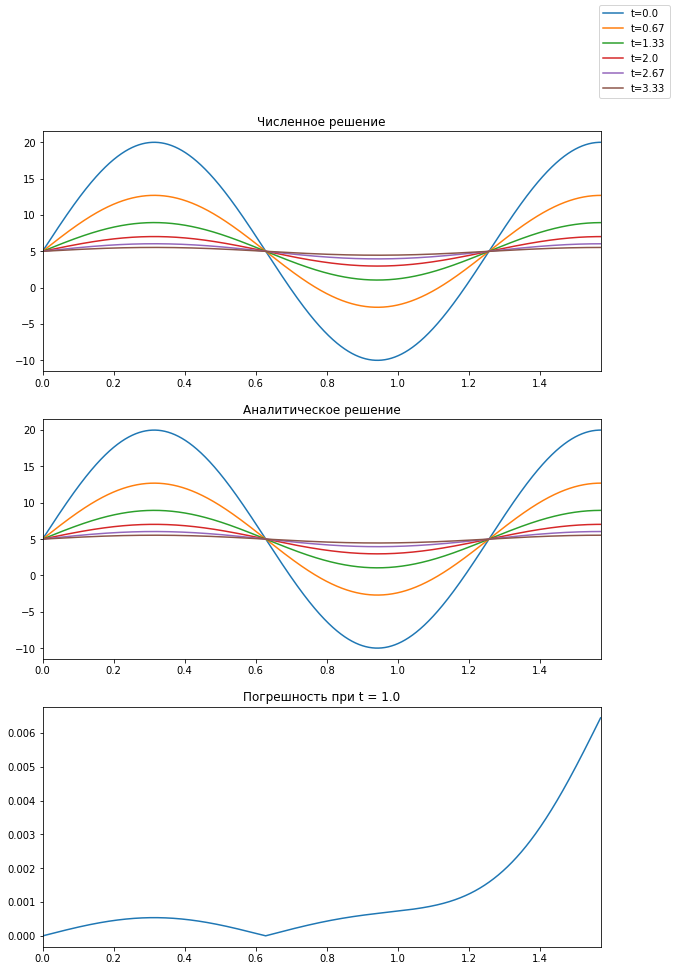

In [12]:
draw(0, l, u2, sol2, u2[3], 6)

In [13]:
df2 = pd.DataFrame(u2[0]) 
df2

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,5120
0,5.0,5.023010,5.046019,5.069029,5.092038,5.115047,5.138056,5.161065,5.184073,5.207081,...,19.998571,19.998871,19.999135,19.999365,19.999559,19.999718,19.999841,19.999929,19.999982,20.000000
1,5.0,5.023005,5.046010,5.069015,5.092020,5.115025,5.138029,5.161033,5.184037,5.207040,...,19.995578,19.995871,19.996128,19.996348,19.996532,19.996679,19.996790,19.996864,19.996901,19.996901
2,5.0,5.023001,5.046001,5.069002,5.092002,5.115003,5.138002,5.161002,5.184001,5.207000,...,19.992589,19.992878,19.993132,19.993349,19.993530,19.993675,19.993784,19.993856,19.993892,19.993892
3,5.0,5.022996,5.045992,5.068988,5.091984,5.114980,5.137975,5.160971,5.183965,5.206960,...,19.989609,19.989896,19.990148,19.990364,19.990544,19.990688,19.990796,19.990868,19.990904,19.990904
4,5.0,5.022992,5.045983,5.068975,5.091966,5.114958,5.137949,5.160939,5.183929,5.206919,...,19.986635,19.986922,19.987173,19.987389,19.987568,19.987711,19.987819,19.987891,19.987927,19.987927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20476,5.0,5.000422,5.000844,5.001265,5.001687,5.002109,5.002531,5.002953,5.003374,5.003796,...,5.271121,5.271126,5.271131,5.271134,5.271138,5.271140,5.271142,5.271144,5.271144,5.271144
20477,5.0,5.000422,5.000843,5.001265,5.001687,5.002109,5.002530,5.002952,5.003374,5.003796,...,5.271067,5.271073,5.271077,5.271081,5.271084,5.271087,5.271089,5.271090,5.271091,5.271091
20478,5.0,5.000422,5.000843,5.001265,5.001687,5.002108,5.002530,5.002952,5.003373,5.003795,...,5.271014,5.271019,5.271023,5.271027,5.271031,5.271033,5.271035,5.271036,5.271037,5.271037
20479,5.0,5.000422,5.000843,5.001265,5.001686,5.002108,5.002529,5.002951,5.003373,5.003794,...,5.270960,5.270965,5.270970,5.270974,5.270977,5.270980,5.270982,5.270983,5.270983,5.270983


In [14]:
a, f, phi, ph1, ph2, l, sol3 = get_entry_conditions(3)

u3 = get_solution(0, l, 0.3, 0.01, phi, a, ph1, ph2, f, 2)

Погрешность: 1.002
Погрешность: 0.647
Погрешность: 0.397
Погрешность: 0.224
Погрешность: 0.121
Погрешность: 0.063
Погрешность: 0.032
Погрешность: 0.016


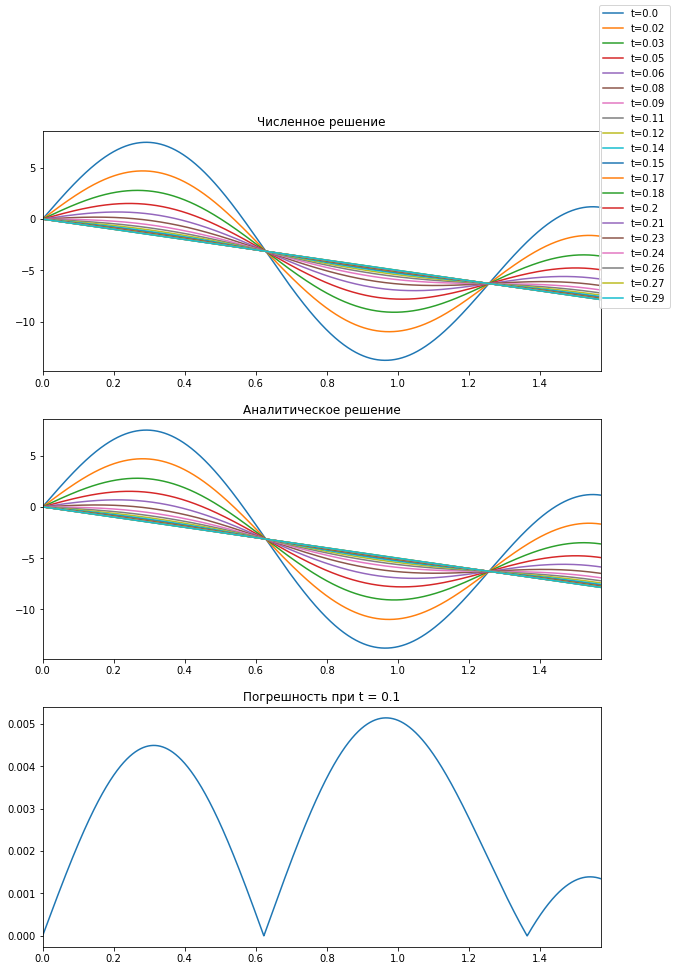

In [15]:
draw(0, l, u3, sol3, u3[3], 20)

In [16]:
df3 = pd.DataFrame(u3[0]) 
df3

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,5120
0,0.0,0.012272,0.024544,0.036815,0.049087,0.061359,0.073630,0.085901,0.098172,0.110443,...,1.158967,1.157613,1.156237,1.154841,1.153424,1.151985,1.150525,1.149044,1.147542,1.146018
1,0.0,0.012205,0.024409,0.036614,0.048819,0.061023,0.073227,0.085431,0.097635,0.109839,...,1.114841,1.113477,1.112092,1.110686,1.109258,1.107809,1.106339,1.104848,1.103335,1.101801
2,0.0,0.012138,0.024276,0.036414,0.048552,0.060689,0.072827,0.084964,0.097101,0.109238,...,1.071091,1.069726,1.068339,1.066932,1.065503,1.064054,1.062583,1.061091,1.059578,1.058044
3,0.0,0.012072,0.024143,0.036215,0.048286,0.060357,0.072428,0.084499,0.096570,0.108640,...,1.027612,1.026245,1.024858,1.023450,1.022020,1.020570,1.019099,1.017607,1.016094,1.014560
4,0.0,0.012005,0.024011,0.036016,0.048022,0.060027,0.072032,0.084036,0.096041,0.108045,...,0.984373,0.983005,0.981617,0.980208,0.978779,0.977328,0.975857,0.974364,0.972851,0.971317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.0,-0.001526,-0.003053,-0.004579,-0.006105,-0.007631,-0.009158,-0.010684,-0.012210,-0.013736,...,-7.836534,-7.838068,-7.839602,-7.841136,-7.842670,-7.844204,-7.845738,-7.847272,-7.848806,-7.850340
1532,0.0,-0.001526,-0.003053,-0.004579,-0.006105,-0.007632,-0.009158,-0.010684,-0.012210,-0.013737,...,-7.836559,-7.838093,-7.839626,-7.841160,-7.842694,-7.844228,-7.845762,-7.847296,-7.848830,-7.850364
1533,0.0,-0.001526,-0.003053,-0.004579,-0.006105,-0.007632,-0.009158,-0.010684,-0.012211,-0.013737,...,-7.836583,-7.838117,-7.839651,-7.841185,-7.842719,-7.844253,-7.845787,-7.847321,-7.848855,-7.850389
1534,0.0,-0.001526,-0.003053,-0.004579,-0.006106,-0.007632,-0.009158,-0.010685,-0.012211,-0.013737,...,-7.836608,-7.838141,-7.839675,-7.841209,-7.842743,-7.844277,-7.845811,-7.847345,-7.848879,-7.850413


In [17]:
a, f, phi, ph1, ph2, l, sol4 = get_entry_conditions(4)

u4 = get_solution(0, l, 0.2, 0.01, phi, a, ph1, ph2, f, 2)

Погрешность: 1.55
Погрешность: 0.976
Погрешность: 0.598
Погрешность: 0.334
Погрешность: 0.176
Погрешность: 0.091
Погрешность: 0.046
Погрешность: 0.023
Погрешность: 0.012


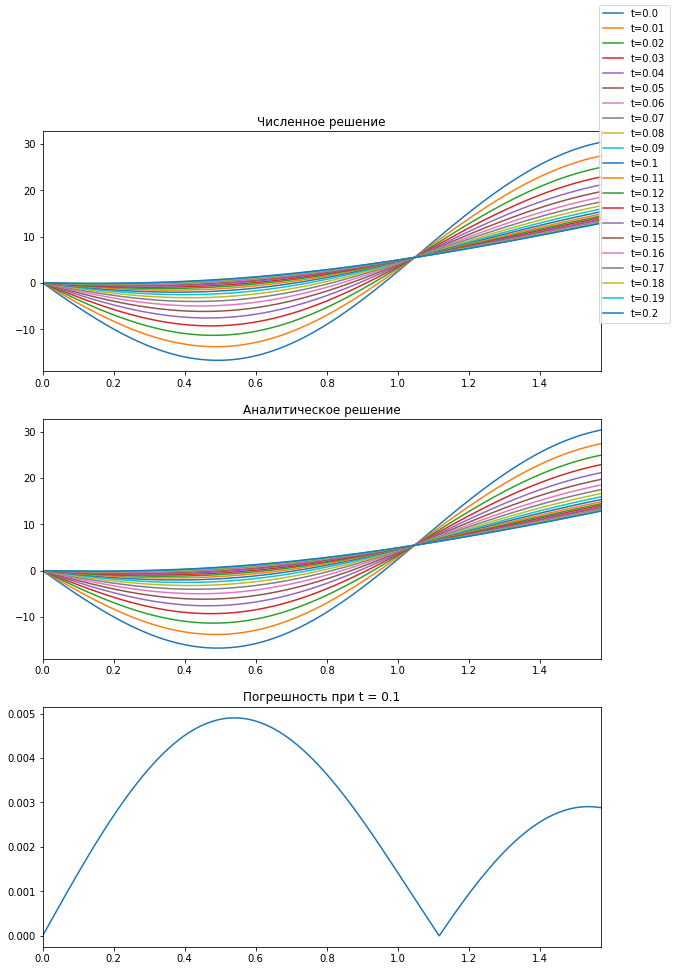

In [18]:
draw(0, l, u4, sol4, u4[3], 20)

In [19]:
df4 = pd.DataFrame(u4[0]) 
df4

,0,1,2,3,4,5,6,7,8,9,...,10231,10232,10233,10234,10235,10236,10237,10238,10239,10240
0,0.0,-0.008283,-0.016567,-0.024849,-0.033132,-0.041415,-0.049697,-0.057979,-0.066260,-0.074542,...,30.315175,30.317614,30.320051,30.322484,30.324913,30.327339,30.329761,30.332179,30.334594,30.337006
1,0.0,-0.008269,-0.016537,-0.024806,-0.033074,-0.041342,-0.049609,-0.057877,-0.066144,-0.074411,...,30.283442,30.285880,30.288315,30.290746,30.293173,30.295597,30.298017,30.300434,30.302847,30.305257
2,0.0,-0.008254,-0.016508,-0.024762,-0.033016,-0.041269,-0.049522,-0.057775,-0.066028,-0.074280,...,30.251831,30.254270,30.256704,30.259135,30.261563,30.263986,30.266407,30.268823,30.271237,30.273646
3,0.0,-0.008240,-0.016479,-0.024719,-0.032958,-0.041197,-0.049436,-0.057674,-0.065912,-0.074150,...,30.220297,30.222735,30.225169,30.227600,30.230028,30.232452,30.234872,30.237289,30.239702,30.242111
4,0.0,-0.008225,-0.016451,-0.024675,-0.032900,-0.041125,-0.049349,-0.057573,-0.065796,-0.074020,...,30.188828,30.191266,30.193700,30.196131,30.198559,30.200982,30.203403,30.205819,30.208232,30.210642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,0.0,-0.000229,-0.000457,-0.000685,-0.000913,-0.001141,-0.001368,-0.001596,-0.001823,-0.002049,...,12.811220,12.813629,12.816037,12.818446,12.820855,12.823264,12.825673,12.828082,12.830492,12.832901
2045,0.0,-0.000228,-0.000456,-0.000684,-0.000912,-0.001139,-0.001366,-0.001593,-0.001819,-0.002046,...,12.810349,12.812757,12.815166,12.817575,12.819984,12.822393,12.824802,12.827211,12.829621,12.832030
2046,0.0,-0.000228,-0.000455,-0.000683,-0.000910,-0.001137,-0.001364,-0.001590,-0.001816,-0.002042,...,12.809479,12.811888,12.814296,12.816705,12.819114,12.821523,12.823932,12.826342,12.828751,12.831161
2047,0.0,-0.000227,-0.000455,-0.000682,-0.000908,-0.001135,-0.001361,-0.001587,-0.001813,-0.002039,...,12.808611,12.811019,12.813428,12.815837,12.818246,12.820655,12.823064,12.825473,12.827883,12.830292


## <center>Моделирование тепловых режимов в зависимости от граничных условий</center>

__Вывод графика:__

In [20]:
def draw_model(a, b, u, n, left, right):
    """
    Рисует график аналитического решения, численного и график погрешности.
    
    Входные параметры:
    a - начальная координата
    b - конечная координата
    u - численное решение
    n - число выводимых временных отрезков
    left - левое граничное условие
    right - правое граничное условие
    
    Выходные параметры:
    график численного решения
    """
    fig = plt.figure(figsize=(9,7))
    
    x = np.linspace(0, l, u[0].shape[1])
    N = u[0].shape[0]
    t = u[2]
            
    plt.title('$\mu_1$ = {};   $\mu_2$ = {}'.format(round(left(0), 4), round(right(0), 4)))
    plt.xlim((0, b))
    for i in range(0, N, round(N / n)):
        plt.plot(x, u[0][i], label='t={}'.format(round(i * t, 2)))
    
    plt.legend()
    plt.show()

__Первая тестовая модель:__

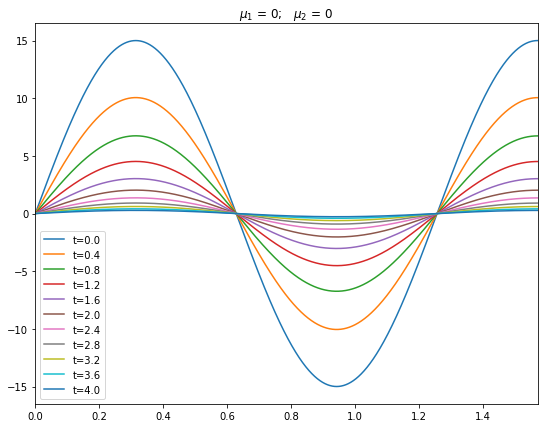

In [21]:
a, f, phi, ph1, ph2, l, sol1 = get_entry_conditions(1)
draw_model(0, l, u1, 10, ph1, ph2)

__Вторая тестовая модель:__

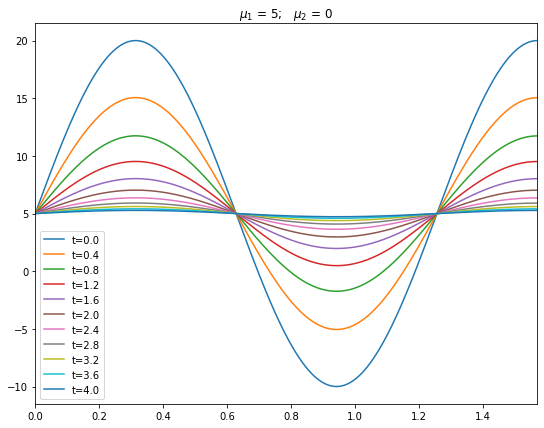

In [22]:
a, f, phi, ph1, ph2, l, sol2 = get_entry_conditions(2)
draw_model(0, l, u2, 10, ph1, ph2)

__Первая собственная модель:__

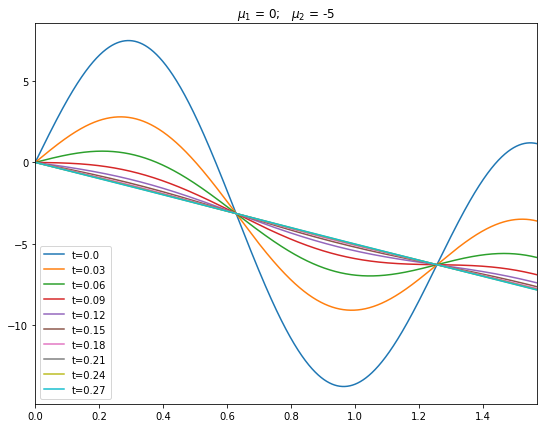

In [24]:
a, f, phi, ph1, ph2, l, sol3 = get_entry_conditions(3)
draw_model(0, l, u3, 10, ph1, ph2)

__Вторая собственная модель:__

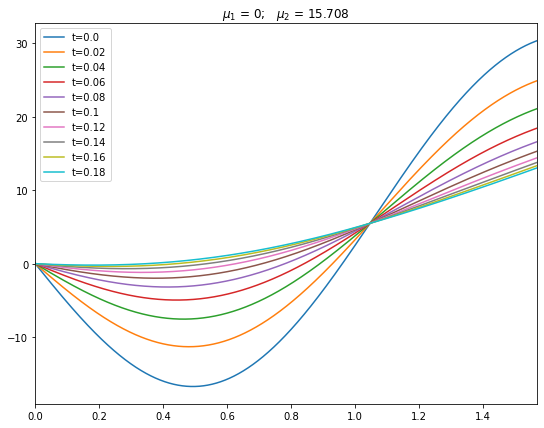

In [25]:
a, f, phi, ph1, ph2, l, sol4 = get_entry_conditions(4)
draw_model(0, l, u4, 10, ph1, ph2)